In [124]:
import pandas as pd
import numpy as np
from pandas import DataFrame

from sklearn.impute import SimpleImputer

from etna.datasets import tsdataset,TSDataset
from etna.models import LinearPerSegmentModel
from etna.transforms import LagTransform
from etna.metrics import R2
from etna.pipeline import Pipeline
from etna.analysis import plot_backtest, plot_correlation_matrix

In [125]:
df=pd.read_csv('data.csv')
df.drop(df.head(5).index, inplace=True)
df.index = range(len(df))
df['0.2']=pd.to_datetime(df['0.2']).dt.date
def add_nan_dates(df, date_column):
    # Преобразуем столбец с датами в тип datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Упорядочиваем даты
    df = df.sort_values(by=date_column).reset_index(drop=True)
    
    # Создаем новый DataFrame с полным диапазоном дат
    all_dates = pd.date_range(start=df[date_column].min(), end=df[date_column].max(),freq='7D')
    full_df = pd.DataFrame(all_dates, columns=[date_column])
    
    # Объединяем с оригинальным DataFrame
    result_df = pd.merge(full_df, df, on=date_column, how='left')
    
    return result_df
df = add_nan_dates(df, '0.2')
df

,0.2,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,0.1
0,2022-01-27,93.58,0.00,1.67,31.17,130.03,6.56,853.49,33.18,28.97,...,3.71,0.22,93.04,23.24,14.76,18.15,44.58,53975.05,0.0,77.6
1,2022-02-03,97.47,0.00,3.76,30.89,136.69,6.37,869.74,33.28,29.04,...,3.70,0.24,99.12,25.17,18.49,14.71,48.48,53074.32,0.0,77.1
2,2022-02-10,83.31,0.00,13.55,31.33,125.23,6.87,860.15,33.47,28.94,...,3.91,0.20,80.79,25.34,18.05,14.71,46.44,53594.28,0.0,83.5
3,2022-02-17,81.52,0.00,0.00,30.81,125.18,6.89,862.88,33.10,28.94,...,4.00,0.16,81.86,23.98,18.17,14.72,45.92,53318.73,0.0,81.1
4,2022-02-24,84.99,0.03,0.00,30.16,124.81,7.61,949.66,32.25,28.85,...,3.90,0.18,85.57,23.08,18.21,14.71,45.12,53566.14,0.0,73.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2024-01-04,103.29,0.00,1.07,36.18,145.32,6.47,939.91,38.35,29.00,...,3.85,0.62,108.94,25.52,18.95,14.75,50.78,50995.08,0.0,88.7
102,2024-01-11,99.05,0.00,0.00,35.27,136.64,6.37,869.96,37.07,29.00,...,3.99,0.27,99.29,25.50,18.59,14.74,48.65,51539.55,0.0,84.1
103,2024-01-18,101.64,0.00,1.38,36.39,139.26,6.32,880.00,38.45,29.00,...,4.00,0.29,101.06,25.73,18.64,14.74,49.41,51661.50,0.0,85.3
104,2024-01-25,122.73,0.00,0.00,31.86,169.95,5.12,870.14,33.46,29.23,...,3.89,0.93,124.49,24.15,19.28,14.74,50.85,50586.76,0.0,105.7


In [126]:
sk_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
for column in df.columns[:-1]:
    sk_imputer.fit(df[[column]])
    df[column]=sk_imputer.transform(df[[column]])
df_target=df[['0.2','0']].copy()
df_regressor=df.drop(columns='0').copy()
df_target=df_target.head(len(df_target)-10)#для работы датасета таргет обязан быть меншье регресора

In [127]:
def from_df_to_dataset(df: DataFrame,date_column: str, segment: str, freq: str|None = None, target_column: str|None=None):

    df[date_column]=pd.to_datetime(df[date_column]).dt.date

    df.rename(columns={date_column:'timestamp'},inplace=True)

    df['segment']=segment

    if target_column:
        df.rename(columns={target_column:'target'},inplace=True)

    return TSDataset.to_dataset(df=df)
ts_target=from_df_to_dataset(df=df_target, date_column='0.2', segment='main', target_column='0')
ts_regressor=from_df_to_dataset(df=df_regressor, date_column='0.2', segment='main')
ts_regressor.tail(5)

segment      main                                                         \
feature       0.1    1      10     11      12      13    14     15    16   
timestamp                                                                  
2024-01-04   88.7  0.0  184.37  27.32  166.00  129.73  4.01  55.71  72.1   
2024-01-11   84.1  0.0  180.80  27.35  164.20  128.65  3.96  60.26  66.0   
2024-01-18   85.3  0.0  181.19  27.35  164.21  128.46  3.94  61.94  69.0   
2024-01-25  105.7  0.0  180.28  27.28  168.18  130.03  3.82  79.31  88.0   
2024-02-01   80.2  0.0  180.85  27.41  164.10  126.20  3.82  65.93  64.5   

segment            ...                                                     \
feature        17  ...     39       4     40        41   42     5       6   
timestamp          ...                                                      
2024-01-04  91.81  ...  14.75  145.32  50.78  50995.08  0.0  6.47  939.91   
2024-01-11  91.97  ...  14.74  136.64  48.65  51539.55  0.0  6.37  869.96   
2024-01-18  92.43  ...  14.74  139.26  49.41  51661.50  0.0  6.32  880.00   
2024-01-25  98.20  ...  14.74  169.95  50.85  50586.76  0.0  5.12  870.14   
2024-02-01  92.92  ...  14.74  125.99  41.14  50663.29  0.0  6.35  800.25   

segment                           
feature         7      8       9  
timestamp                         
2024-01-04  38.35  29.00  167.00  
2024-01-11  37.07  29.00  165.34  
2024-01-18  38.45  29.00  165.27  
2024-01-25  33.46  29.23  169.28  
2024-02-01  35.54  28.96  165.30  

[5 rows x 43 columns]

In [128]:
ts=TSDataset(df=ts_target,df_exog=ts_regressor,freq='W-THU', known_future='all')
ts

segment     main                                                           \
feature      0.1     1      10     11      12      13    14     15     16   
timestamp                                                                   
2022-01-27  77.6  0.00  176.09  27.76  158.06  125.90  3.86  60.90  67.00   
2022-02-03  77.1  0.00  171.97  27.71  154.73  125.67  3.83  60.99  68.00   
2022-02-10  83.5  0.00  176.87  27.76  157.98  126.16  3.84  59.96  66.00   
2022-02-17  81.1  0.00  177.66  27.73  159.00  127.03  3.83  62.83  63.16   
2022-02-24  73.9  0.03  186.32  27.70  164.00  128.04  3.83  59.10  64.00   
...          ...   ...     ...    ...     ...     ...   ...    ...    ...   
2023-10-26  91.2  0.00  170.51  27.54  159.92  128.27  4.35  65.08  80.10   
2023-11-02  94.2  0.00  170.49  27.55  159.60  127.59  4.35  65.01  77.09   
2023-11-09  93.1  0.00  170.81  27.58  160.01  127.57  4.35  64.88  73.06   
2023-11-16  90.4  0.00  170.68  27.70  157.97  125.41  4.10  63.39  62.90   
2023-11-23  81.6  0.00  170.88  27.70  158.02  126.92  4.35  65.77  64.00   

segment            ...                                                     \
feature        17  ...       4     40        41   42     5       6      7   
timestamp          ...                                                      
2022-01-27  91.10  ...  130.03  44.58  53975.05  0.0  6.56  853.49  33.18   
2022-02-03  90.78  ...  136.69  48.48  53074.32  0.0  6.37  869.74  33.28   
2022-02-10  91.77  ...  125.23  46.44  53594.28  0.0  6.87  860.15  33.47   
2022-02-17  92.76  ...  125.18  45.92  53318.73  0.0  6.89  862.88  33.10   
2022-02-24  90.75  ...  124.81  45.12  53566.14  0.0  7.61  949.66  32.25   
...           ...  ...     ...    ...       ...  ...   ...     ...    ...   
2023-10-26  95.71  ...  159.38  51.94  51727.98  0.0  4.40  700.50  40.63   
2023-11-02  95.20  ...  156.05  49.03  51782.31  0.0  4.46  694.97  39.18   
2023-11-09  96.00  ...  152.04  44.72  51374.86  0.0  4.43  675.04  39.43   
2023-11-16  93.74  ...  129.03  46.96  52756.76  0.0  4.81  619.98  39.72   
2023-11-23  95.07  ...  129.29  47.03  52245.64  0.0  4.88  630.02  39.10   

segment                            
feature         8       9  target  
timestamp                          
2022-01-27  28.97  159.31   93.58  
2022-02-03  29.04  155.87   97.47  
2022-02-10  28.94  159.11   83.31  
2022-02-17  28.94  160.19   81.52  
2022-02-24  28.85  165.33   84.99  
...           ...     ...     ...  
2023-10-26  29.19  160.86  111.30  
2023-11-02  29.17  160.67  114.51  
2023-11-09  29.14  161.05  108.77  
2023-11-16  29.03  159.17   93.33  
2023-11-23  29.02  159.28   92.42  

[96 rows x 44 columns]

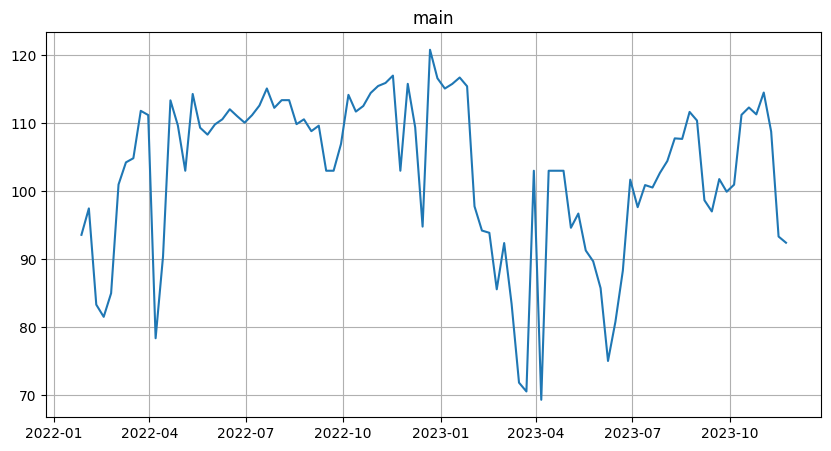

In [129]:
ts.plot()

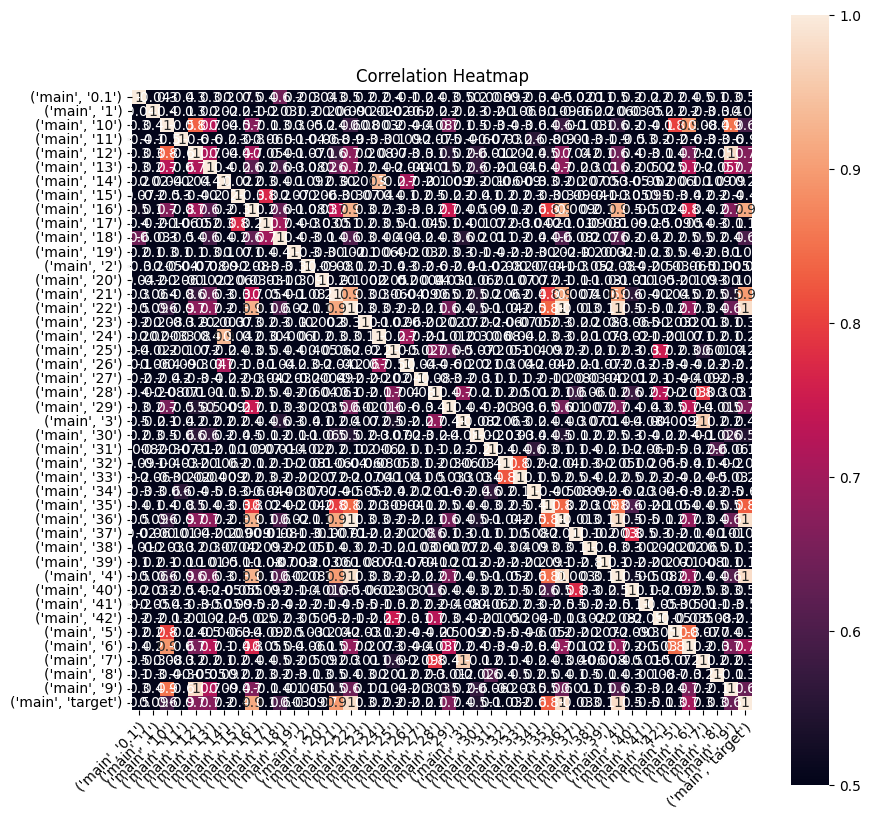

In [130]:
plot_correlation_matrix(ts, segments=["main"], method="spearman", vmin=0.5, vmax=1)

In [131]:
HORIZON = 5
model = LinearPerSegmentModel()
transform = []
pipeline = Pipeline(model = model, transforms=transform, horizon=HORIZON)

In [132]:
metrics, forecasts, _ = pipeline.backtest(ts, metrics=[R2()], aggregate_metrics=True, n_folds=2)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s


In [133]:
metrics

,segment,R2
0,main,0.877749


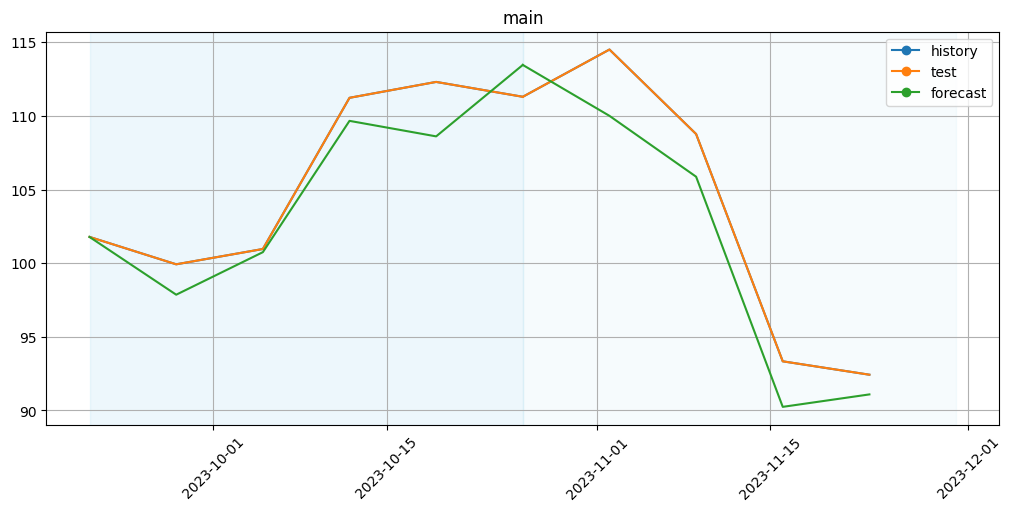

In [134]:
plot_backtest(forecasts, ts)